# Q1
## 1.1

We consider a multi-object linear Gaussian Hidden Markov Model (MOHMM) for tracking $K$ interacting objects. Each object evolves in a 4-dimensional state space (position and velocity), and the overall system is modeled using Kronecker products to build block-diagonal matrices.

\textbf{Base HMM:}
\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; A x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

\textbf{Model parameters:}
\begin{align*}
A &= \begin{bmatrix}
I_2 & \kappa I_2 \\
0_{2\times 2} & 0.99 I_2
\end{bmatrix}, \quad
H = I_4, \quad
Q = \begin{bmatrix}
\frac{\kappa^3}{3} I_2 & \frac{\kappa^2}{2} I_2 \\
\frac{\kappa^2}{2} I_2 & \kappa I_2
\end{bmatrix}, \quad
R = r I_4
\end{align*}

To scale this model to $K$ objects, we define:
\begin{align*}
\bar{A}_K = I_K \otimes A, \quad
Q_K = I_K \otimes Q, \quad
\bar{H}_K = I_K \otimes H, \quad
\bar{R}_K = I_K \otimes R
\end{align*}

To introduce interaction among targets, we modify $Q_K$ as:
\[
\bar{Q}_K = Q_K + L L^\top,
\]
where $L$ is a zero-mean Gaussian random matrix with standard deviation $\sigma_L$.



- Sample $x_0 \sim \mathcal{N}(m_0^{(K)}, P_0^{(K)})$
- For $t = 1$ to $T$:

    - Sample $x_t \sim \mathcal{N}(\bar{A}_K x_{t-1}, \bar{Q}_K)$
    - Sample $y_t \sim \mathcal{N}(\bar{H}_K x_t, \bar{R}_K)$
    


We implemented the above simulator and tested it for $K = 1, 2, 5$ objects. For each case, we plot the observed data $y_t$ and the first two dimensions of the true trajectories of each object.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_MOHMM(K, T=400, kappa=0.1, r=0.1, sigma_L=0.5, seed=42):
    if seed is not None:
        np.random.seed(seed)

    I2 = np.eye(2)
    I4 = np.eye(4)

    A = np.block([
        [I2, kappa * I2],
        [np.zeros((2, 2)), 0.99 * I2]
    ])

    Q = np.block([
        [(kappa**3 / 3) * I2, (kappa**2 / 2) * I2],
        [(kappa**2 / 2) * I2, kappa * I2]
    ])

    H = I4
    R = r * I4

    # Block-diagonal for K objects
    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    dim = 4 * K
    L = np.random.normal(0, sigma_L, size=(dim, dim))
    Q_bar_K = QK + L @ L.T

    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)
    x = np.random.multivariate_normal(m0, P0)

    X = [x.copy()]
    Y = []

    for _ in range(T):
        x = np.random.multivariate_normal(AK @ x, Q_bar_K)
        y = np.random.multivariate_normal(HK @ x, RK)
        X.append(x.copy())
        Y.append(y.copy())

    X = np.array(X)  # shape: (T+1, 4K)
    Y = np.array(Y)  # shape: (T, 4K)
    return X, Y

def plot_trajectories(X_list, K_list):
    plt.figure(figsize=(5, 5))
    
    for X, K in zip(X_list, K_list):
        for k in range(K):
            pos_x = X[:, 4*k + 0]
            pos_y = X[:, 4*k + 1]
            label = f"K={K}, Obj {k+1}"
            plt.plot(pos_x, pos_y, label=label)
    
    plt.xlabel("Position X")
    plt.ylabel("Position Y")
    plt.title("True Trajectories of Objects (First Two Dimensions)")
    plt.legend(prop={'size': 6})
    plt.grid(True)
    plt.tight_layout()
    plt.show()



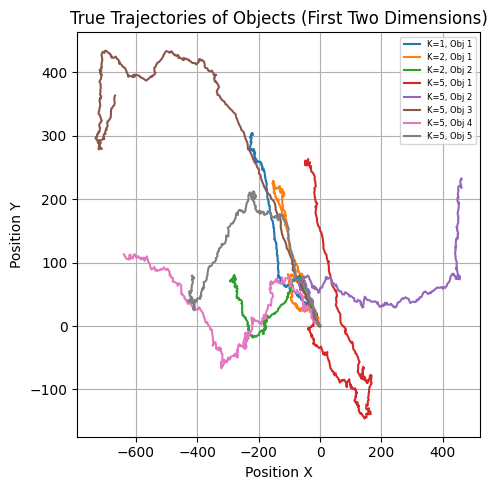

In [2]:
X1, Y1 = simulate_MOHMM(K=1, seed=42)
X2, Y2 = simulate_MOHMM(K=2, seed=42)
X5, Y5 = simulate_MOHMM(K=5, seed=42)

plot_trajectories([X1, X2, X5], [1, 2, 5])


## 1.2 Kalman Filter

### (a)

We consider the standard Kalman filtering algorithm applied to the high-dimensional linear Gaussian state-space model constructed for multiple-object tracking.

Let the state transition and observation models be:
\begin{align*}
x_0 &\sim \mathcal{N}(m_0, P_0) \\
x_t \mid x_{t-1} &\sim \mathcal{N}(A x_{t-1}, Q) \\
y_t \mid x_t &\sim \mathcal{N}(H x_t, R)
\end{align*}

At each time step $t$, the Kalman filter computes the posterior distribution
\[
p(x_t \mid y_{1:t}) = \mathcal{N}(x_t; m_t, P_t)
\]

The algorithm consists of two stages:

- Prediction step:
\begin{align*}
\hat{m}_t &= A m_{t-1} \\
\hat{P}_t &= A P_{t-1} A^\top + Q
\end{align*}

- Update step:
\begin{align*}
K_t &= \hat{P}_t H^\top (H \hat{P}_t H^\top + R)^{-1} \\
m_t &= \hat{m}_t + K_t (y_t - H \hat{m}_t) \\
P_t &= (I - K_t H) \hat{P}_t
\end{align*}

Here, $K_t$ is the Kalman gain matrix, and $m_t$, $P_t$ represent the posterior mean and covariance of the filtered state estimate at time $t$.


In [3]:
def kalman_filter(Y, A, Q, H, R, m0, P0):
    T = len(Y)
    dim_x = len(m0)
    I = np.eye(dim_x)

    m = m0.copy()
    P = P0.copy()
    M_list = []
    P_list = []

    for t in range(T):
        # Prediction step
        m_pred = A @ m
        P_pred = A @ P @ A.T + Q

        # Update step
        y = Y[t]
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        m = m_pred + K @ (y - H @ m_pred)
        P = (I - K @ H) @ P_pred

        M_list.append(m.copy())
        P_list.append(P.copy())

    return np.array(M_list), P_list


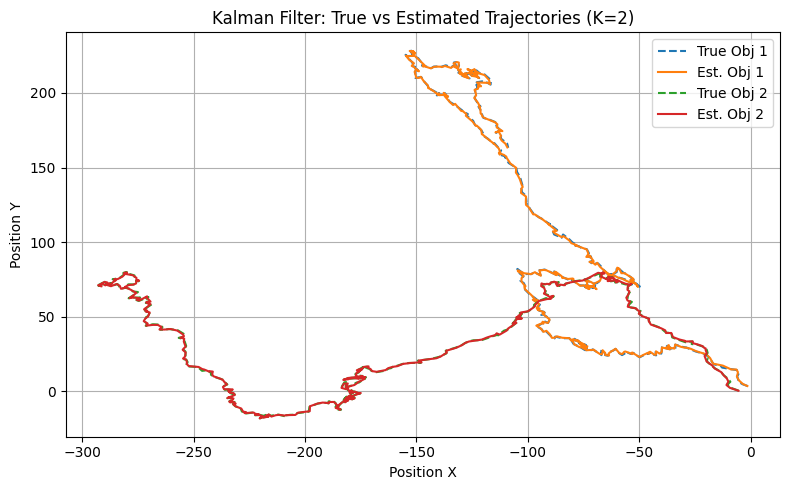

1.6957430836060906e-05

In [4]:
def compute_nmse(true, est):
    """
    NMSE over sequence: true and est are shape (T+1, dim)
    """
    num = np.sum((true[1:] - est)**2)
    denom = np.sum(true[1:]**2)
    return num / denom

def run_kalman(X, Y, K, T=400, plot_trajectories = False):
    dim = 4 * K
    I2 = np.eye(2)
    I4 = np.eye(4)
    kappa = 0.1
    r = 0.1
    
    A = np.block([
        [I2, kappa * I2],
        [np.zeros((2, 2)), 0.99 * I2]
    ])
    Q = np.block([
        [(kappa**3 / 3) * I2, (kappa**2 / 2) * I2],
        [(kappa**2 / 2) * I2, kappa * I2]
    ])
    H = I4
    R = r * I4

    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    # Add interaction noise
    L = np.random.normal(0, 0.5, size=(dim, dim))
    Q_bar = QK + L @ L.T

    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)

    # Step 2: Kalman filtering
    filtered_means, _ = kalman_filter(Y, AK, Q_bar, HK, RK, m0, P0)

    # Step 3: NMSE
    nmse = compute_nmse(X, filtered_means)

    # Step 4: Plot true vs estimated (position only)
    if plot_trajectories: 
        plt.figure(figsize=(8, 5))
        for k in range(K):
            idx_x = 4*k
            idx_y = 4*k + 1
            plt.plot(X[1:, idx_x], X[1:, idx_y], label=f"True Obj {k+1}", linestyle="--")
            plt.plot(filtered_means[:, idx_x], filtered_means[:, idx_y], label=f"Est. Obj {k+1}")
        plt.xlabel("Position X")
        plt.ylabel("Position Y")
        plt.title(f"Kalman Filter: True vs Estimated Trajectories (K={K})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return nmse

# Run it
run_kalman(X2, Y2, K=2, plot_trajectories=True)


In [5]:
state_dims = 4 * np.arange(1, 21)
state_dims

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68,
       72, 76, 80])

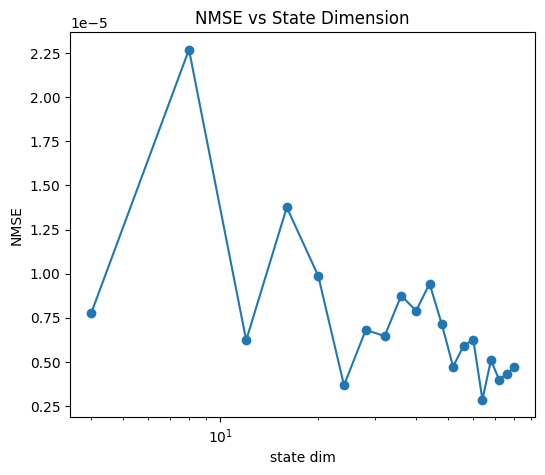

In [ ]:
nmse_list = []
for K in range(1, 21):
    X, Y = simulate_MOHMM(K)
    nmse = run_kalman(X, Y, K)
    # print(f"K={K}, NMSE={nmse:.4f}")
    nmse_list.append(nmse)
nmse_list = np.array(nmse_list)


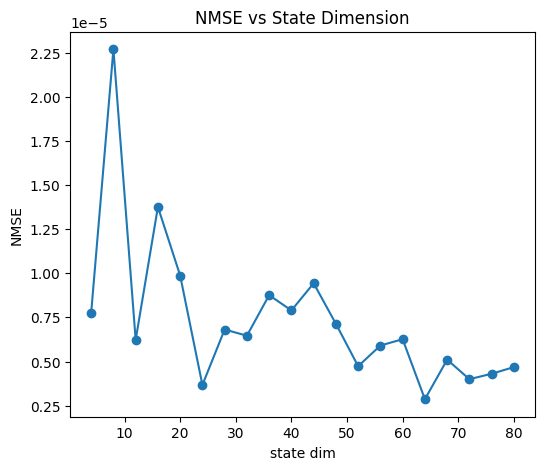

In [8]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_list, marker='o')
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs State Dimension")
plt.show()

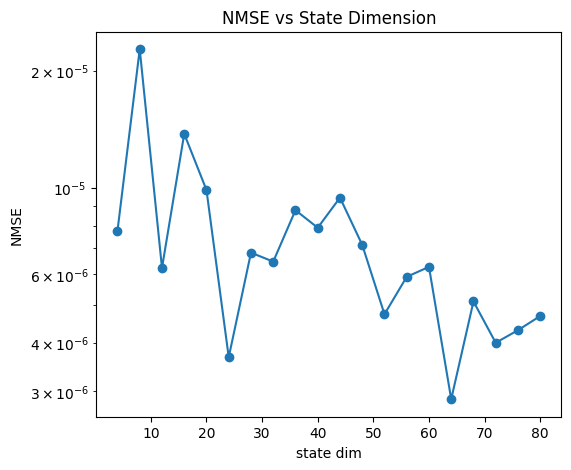

In [9]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_list, marker='o')
plt.yscale("log")
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs State Dimension")
plt.show()

## 1.3

### (a)

- **Goal**: Sequentially approximate the filtering distribution $p(x_t \mid y_{1:t})$ where

  $$
  x_t \sim p(x_t \mid x_{t-1}), \qquad
  y_t \sim p(y_t \mid x_t).
  $$

- **Idea**: Maintain $N$ weighted particles $\{x_t^{(i)},w_t^{(i)}\}_{i=1}^N$.
- **Algorithm steps**:
  - Propagate: sample $x_t^{(i)} \sim p(x_t \mid x_{t-1}^{(i)})$.
  - Weight: set $w_t^{(i)} \propto p(y_t \mid x_t^{(i)})$.
  - Normalise weights so that $\sum_{i=1}^N w_t^{(i)} = 1$.
  - Resample according to $\{w_t^{(i)}\}$ and reset $w_t^{(i)} = 1/N$.

\begin{array}{l}
\textbf{Initialise:} \\
\quad \text{for } i = 1,\dots,N: \; x_0^{(i)} \sim p(x_0),\; w_0^{(i)} = \tfrac{1}{N} \\[6pt]
\textbf{For } t = 1,\dots,T: \\
\quad \text{(1) Propagate } x_t^{(i)} \sim p(x_t \mid x_{t-1}^{(i)}). \\[4pt]
\quad \text{(2) Weight } w_t^{(i)} = p(y_t \mid x_t^{(i)}). \\[4pt]
\quad \text{(3) Normalise } w_t^{(i)} \leftarrow w_t^{(i)} \big/ \sum_{j=1}^N w_t^{(j)}. \\[4pt]
\quad \text{(4) Resample } \{x_t^{(i)}\} \text{ according to } \{w_t^{(i)}\},\; w_t^{(i)} = \tfrac{1}{N}. \\
\end{array}



Inputs: N (number of particles), observations y1:T
Output: filtered particles {x_t^{(i)}, w_t^{(i)}} for t = 1…T

1.  INITIALISATION
2.  for i = 1 … N do
3.        draw x_0^{(i)} ~ p(x_0)
4.        set w_0^{(i)} ← 1/N
5.  end for

6.  RECURSION
7.  for t = 1 … T do
8.        PROPAGATE
9.        for i = 1 … N do
10.             draw x_t^{(i)} ~ p(x_t | x_{t-1}^{(i)})
11.        end for
12.
13.       WEIGHT
14.       for i = 1 … N do
15.             w_t^{(i)} ← p(y_t | x_t^{(i)})
16.       end for
17.       normalise {w_t^{(i)}} so that Σ_i w_t^{(i)} = 1
18.
19.       RESAMPLE
20.       resample N particles {x_t^{(i)}} with probabilities {w_t^{(i)}}
21.       reset w_t^{(i)} ← 1/N  for all i
22. end for

### (b) Implement BPF

In [10]:
from typing import Callable, Tuple


class BootstrapParticleFilter:
    def __init__(
        self,
        n_particles: int,
        transition_fn: Callable[[np.ndarray], np.ndarray],
        likelihood_fn: Callable[[np.ndarray, np.ndarray], np.ndarray],
        init_sampler: Callable[[int], np.ndarray],
        resample_threshold: float = 0.5,
        rng: np.random.Generator | None = None,
    ):
        """
        Parameters
        ----------
        n_particles      : number of particles N
        transition_fn    : f(x_prev) → x_next draw(s)
        likelihood_fn    : g(x, y)   → likelihood p(y | x)
        init_sampler     : h(N)      → N draws from p(x₀)
        resample_threshold : ESS / N below which resampling is triggered
        rng              : NumPy random generator (optional)
        """
        self.N = n_particles
        self.trans = transition_fn
        self.like = likelihood_fn
        self.init = init_sampler
        self.thresh = resample_threshold
        self.rng = rng or np.random.default_rng()

        # state
        self.x = self.init(self.N)             # particles
        self.w = np.full(self.N, 1.0 / self.N) # weights
        self.t = 0                             # time index

    # ------------------------------------------------------------ #
    # public API
    # ------------------------------------------------------------ #
    def predict(self) -> None:
        """Propagate particles through the transition prior."""
        self.x = self.trans(self.x)            # shape (N, …)

    def update(self, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Assimilate a new observation yₜ.

        Returns
        -------
        mean, var : np.ndarray
            Weighted mean and (unbiased) variance estimate of the state.
        """
        # weight
        self.w *= self.like(self.x, y)
        self._normalise()

        # (optional) diagnostics
        mean = np.average(self.x, weights=self.w, axis=0)
        var  = np.average((self.x - mean) ** 2, weights=self.w, axis=0)

        # resample if necessary
        if self._ess() < self.thresh * self.N:
            self._systematic_resample()

        self.t += 1
        return mean, var

    # ------------------------------------------------------------ #
    # helpers
    # ------------------------------------------------------------ #
    def _normalise(self) -> None:
        self.w /= np.sum(self.w)

    def _ess(self) -> float:
        """Effective sample size (ESS)."""
        return 1.0 / np.sum(self.w ** 2)

    def _systematic_resample(self) -> None:
        """
        Systematic resampling (O(N)):

            ░ ░ ░ ░ ░ ░ ░|—|—|—|—|—|—|—|—|—|—  ← cumulative weights
          u  └─────┬────┘└──┬──┘   ...
                   k₀       k₁

        Ensures low-variance particle selection.
        """
        cdf = np.cumsum(self.w)
        u0  = self.rng.random() / self.N
        js  = u0 + np.arange(self.N) / self.N
        idx = np.searchsorted(cdf, js, side="right")
        self.x = self.x[idx]
        self.w.fill(1.0 / self.N)

RMSE ≈ 1.200


In [14]:
N = 500  # fixed number of particles
K_range = range(1, 21)
nmse_bpf = []
# a, q, r = 0.9, 1.0, 4.0
T = 50
rng = np.random.default_rng(seed=0)

for K in K_range:
    # Define model parameters for this K
    # Example (adjust this logic to match your Kalman Filter setup)
    a_K = 0.5 + 0.02 * K
    q_K = 1.0
    r_K = 4.0

    def init_sampler(n):
        return rng.normal(0.0, np.sqrt(q_K / (1 - a_K**2)), size=n)

    def transition_fn(x_prev):
        return a_K * x_prev + rng.normal(0.0, np.sqrt(q_K), size=x_prev.shape)

    def likelihood_fn(x, y):
        return np.exp(-0.5 * (y - x) ** 2 / r_K) / np.sqrt(2 * np.pi * r_K)

    # Generate synthetic data (same for both KF and BPF)
    x_true = np.empty(T)
    y_obs = np.empty(T)
    x = init_sampler(1)[0]
    for t in range(T):
        x = transition_fn(np.array([x]))[0]
        y = x + rng.normal(0.0, np.sqrt(r_K))
        x_true[t], y_obs[t] = x, y

    # Run BPF with N=500
    bpf = BootstrapParticleFilter(
        n_particles=N,
        transition_fn=transition_fn,
        likelihood_fn=likelihood_fn,
        init_sampler=init_sampler,
        resample_threshold=0.5,
        rng=rng,
    )
    est = np.empty(T)
    for t, y in enumerate(y_obs):
        bpf.predict()
        mean, _ = bpf.update(y)
        est[t] = mean

    # Compute NMSE
    nmse = np.sum((est - x_true) ** 2) / np.sum(x_true ** 2)
    print(f"K = {K:2d}, NMSE = {nmse:.4f}")
    nmse_bpf.append(nmse)


K =  1, NMSE = 0.6428
K =  2, NMSE = 0.5200
K =  3, NMSE = 0.7333
K =  4, NMSE = 0.5563
K =  5, NMSE = 0.5647
K =  6, NMSE = 0.6962
K =  7, NMSE = 0.5525
K =  8, NMSE = 0.5116
K =  9, NMSE = 0.4794
K = 10, NMSE = 0.4047
K = 11, NMSE = 0.6762
K = 12, NMSE = 0.4668
K = 13, NMSE = 0.3470
K = 14, NMSE = 0.6568
K = 15, NMSE = 0.4853
K = 16, NMSE = 0.3686
K = 17, NMSE = 0.2748
K = 18, NMSE = 0.4882
K = 19, NMSE = 0.4339
K = 20, NMSE = 0.2223


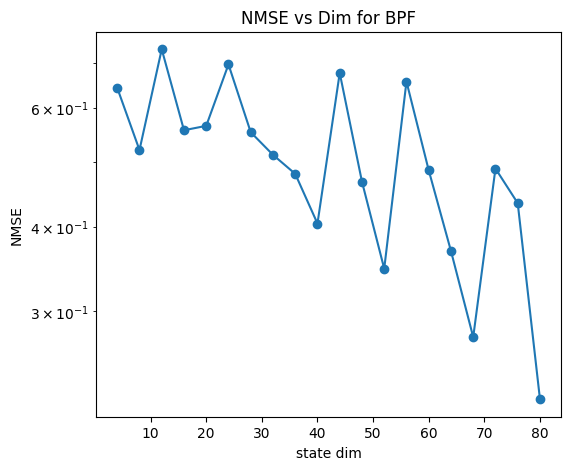

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf, marker='o')
plt.yscale("log")
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim for BPF")
plt.show()

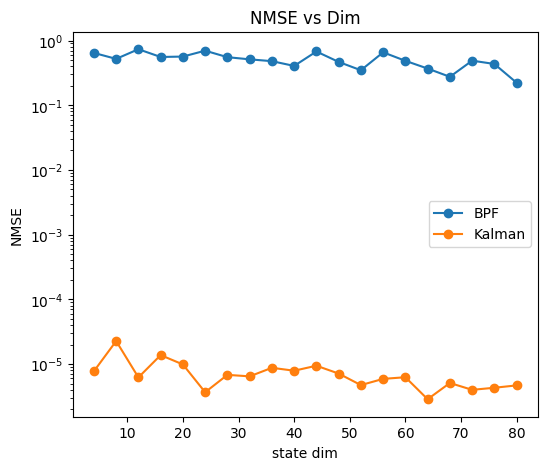

In [17]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf, marker='o')
plt.plot(state_dims, nmse_list, marker='o')
plt.legend(["BPF", "Kalman"])
plt.yscale("log")
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim")
plt.show()